In [8]:
import sys
import os.path
import warnings
import csv

import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit, OptimizeWarning

from echodet_reader import read_wbfile, write_csv

warnings.filterwarnings('ignore', '', RuntimeWarning)
warnings.filterwarnings('error' , '', OptimizeWarning)

In [9]:
def fit_sqt(q, data, model='Zilman-Granek', **kwargs):

    A    = kwargs.pop('A',  1.0)
    A1   = kwargs.pop('A1',  1.0)
    G    = kwargs.pop('G',  1.0)
    t0   = kwargs.pop('t0', 1.0)
    t1   = kwargs.pop('t1', 1.0)
    beta = kwargs.pop('beta', 2.0/3.0)
    R    = kwargs.pop('R', 1.0)
    bounds  = kwargs.pop('bounds', (-np.inf, np.inf))
    init_par = kwargs.pop('init_par', None)
    max_tau = kwargs.pop('max_tau', np.inf)

    function_library = {
        'KWW'            : lambda t, t0, beta:         np.exp(-(t/t0)**beta),   # simple KWW
        'KWW-Fix'        : lambda t, t0:               np.exp(-(t/t0)**beta),   # KWW with beta fixed
        'KWW-Norm'       : lambda t, t0, beta, A:    A*np.exp(-(t/t0)**beta),   # KWW with prefactor
	    'KWW-Norm2'      : lambda t, t0, t1,beta, A, A1: A*np.exp(-(t/t0)**beta) + A1*np.exp(-(t/t1)**beta),   # KWW with prefactor
        'KWW-Norm-Fix'   : lambda t, t0, A:          A*np.exp(-(t/t0)**beta),   # KWW with prefactor and beta fixed
        'Zilman-Granek'  : lambda t, G:                np.exp(-(G*t)**beta),    # Zilman-Granek, KWW with b=2/3
        'Zilman-Granek-Norm'  : lambda t, G, A:      A*np.exp(-(G*t)**beta),    # Zilman-Granek, KWW with b=2/3
        'Exp'            : lambda t, t0, A:          A*np.exp(-(t/t0)),         # simple exponential function
        'Diffusion'      : lambda t, G:                np.exp(-G*q*q*t),        # simple diffusion
        'Diffusion-Norm' : lambda t, G,  A:          A*np.exp(-G*q*q*t),        # simple diffusion with prefactor
        'Diffusion+Const': lambda x, G,  A:      (1-A)*np.exp(-G*q*q*x)+A,      # simple diffusion with constant "background"
        'Power'          : lambda x, b,  A:      A*x**b,                        # power law
        'Linear'         : lambda x, x0, A:      A*(x-x0),                      # linear function
        'Constant'       : lambda x, A:          A*np.ones_like(x),             # constant
        'Cumulant'       : lambda x, c1, c2:     np.exp(-c1*x+c2*x**2/2.0),     # 2nd cumulant
        'Diffusion+2ND'  : lambda t, G,  c2:     np.exp(-G*q*q*t+c2*t*t) ,      # diffusion + 2nd cumuland
        'Richter-Rouse-Norm': lambda t, Ws, A: A*np.exp(-0.25*(q*R)**2) + A*(1-np.exp(-0.25*(q*R)**2))*np.exp(-q**2*np.sqrt(Ws*t/9/np.pi)), # RR
        'Richter-Rouse'  : lambda t, Ws, R:      np.exp(-0.25*(q*R)**2) +   (1-np.exp(-0.25*(q*R)**2))*np.exp(-q**2*np.sqrt(Ws*t/9/np.pi)), # RR
    }

    tau  = data[0]
    sqt  = data[1]
    serr = data[2]

    func = function_library.get(model, None)
    if func is None: raise RuntimeError(f"model {model} is invalid")

    best_values, covar = curve_fit(func, tau[tau<max_tau], sqt[tau<max_tau], 
                           sigma=serr[tau<max_tau], p0=init_par,
                             maxfev=10000, ftol=1e-5)
    #popt gives all the best value parameters in order of your function
    par, epar  = best_values[0], np.sqrt(covar[0,0])
    perr = np.sqrt(np.diag(covar))
    fit_func = lambda x : func(x, *best_values)
    chisq = np.sum(((fit_func(tau[tau<max_tau]) - sqt[tau<max_tau])/serr[tau<max_tau])**2)
    chisq = chisq/(len(sqt[tau<max_tau]) - len(best_values))
    return (par,epar,fit_func, chisq, best_values,perr)

In [10]:
def read_wbfile(filename):
    """
    Read b/w files produced by echodet
    
    Returns list of (metadata, data) pairs
    """
    result = []             # result
    data   = []             # data
    meta   = OrderedDict()  # meta data
    isdata = False
    iline  = 0
 
    with open(filename, 'rt') as fd:
        for line in fd.readlines():
            line = line.strip()
            if not line: continue
            iline += 1
            if iline <= 2:  # first two lines are info
                meta[f'info{iline}'] = line
                continue
            if line  == 'values':  # values indicate start of data block
                isdata = True
                continue
            if line == '#eod' or line == '#nxt':
                result.append((meta,np.asarray(data).T))
                data = []
                meta = OrderedDict()
                isdata = False
                iline  = 0
                if line == '#eod': break
                continue
      
            xl = line.split()
            if isdata:
                try:
                    data.append([float(x) for x in xl])
                except ValueError:
                    pass
            else:
                key   = xl[0]
                value = " ".join(xl[1:])
                try:
                    meta[key] = eval(value)
                except (ValueError, SyntaxError, NameError):
                    meta[key] = value
    return result

In [11]:
def write_csv(filename, data, **kwargs):
    header = ["%s" % kwargs.pop('label'),]
    for key in kwargs:
        header.append("%s, %s" % (key, kwargs.get(key)))
    header.append(" ")
    header.append("%13.13s%13.13s%13.13s" % ("tau","S(Q,t)","dS(Q,t)"))
    np.savetxt(filename, data.T, fmt='%13.6f',header="\n".join(header), delimiter=',')

In [12]:
def prune_data(data, min_points=3, min_taus=3):
    """
    Prune/cleanup DrSPINE reduced data

    """
    if not len(data):
        return None
    data =  data.T
    data = data[data[:,5]>min_points] # at least min_points contributing points
    data = data[data[:,4]>0] # var(tau)
    data = data[data[:,3]>0] # var(sqt)
    data = data[data[:,2]>0] # err(sqt)
    data = data[data[:,1]>0] # require positive resultant sqt
    if len(data[:,4])<min_taus: # at least min_taus "good" taus
        return None
    return data.T

In [13]:
def main(*args, **kwargs):
    """
    main function of the stapler
    DOCS: to do
    """
    model = kwargs.pop('model', 'KWW-Norm') # fit model (see fit_sqt)
    mpars = kwargs.pop('model_pars', {} )   # model parameters
    rings = kwargs.pop('rings', (0,)   )    # which q-rings to use
    plot_summary = kwargs.pop('plot_summary', True)
    plot_fits    = kwargs.pop('plot_fits', True)
    data_dir     = kwargs.pop('data_dir', 'Data')
    shift        = kwargs.pop('shift', 0.0)
    other_data   = kwargs.pop('other_data', None)


    results = []           # list of fit results
    print("# ", model)
    for sample in args:
        label  = sample[0]  # sample is defined like [ r'VES1', ("VES1_sqt1.dat",""),]
        print("############# ", label, "###################")
        if model.startswith('Diffusion'):
            print("# q     dq      D          dD         chi2  extra_pars")
        elif model.startswith('Zilman'):
            print("# q     dq      Gamma      dGamma     chi2  extra_pars")
        elif model.startswith('Richter'):
            print("# q     dq      Wsigma4    dWsigma4   chi2  extra_pars")
        elif model.startswith('KWW-Norm2'):
            print("# q     dq      tau0       dtau0      chi2     tau1     beta     A     A1")
        else:
            print("# q     dq      tau0       dtau0      chi2  extra_pars")
        if plot_fits:
            plt.figure(figsize=(8,8))
        fitres = []
        outfile = label.replace('/','_').replace(' ','_').replace('=','').lower() # nice file name

        d_sqt = 0.0 # data shift for presentation
        for filename, slabel in sample[1:]:
            filename = os.path.join(data_dir, filename)
            if not os.path.exists(filename): continue
            dset = read_wbfile(filename)
            for m, d in reversed(dset):
                d     = prune_data(d, min_points=4)
                if d is None: continue
                q  = m['q']
                if q == 'NaN': continue

                dq   = m['q_var'] or 0.0
                tsam = m.get('temp_act') or m.get('temp')
                tau  = d[0]
                sqt  = d[1]
                dsqt = d[2]

                alabel = r"Q=%.3f $\AA^{-1}$ %s" % (q, slabel)
                if plot_fits:
                    p = plt.errorbar(tau, sqt+d_sqt, yerr=dsqt,fmt='s', label=alabel)
                    acolor = p[0].get_color()
                par0, epar0, fit_func, chi2, best_values,perr = fit_sqt(q, d, model=model, 
                                            p0=[2.5, 7.6,-0.00028,	-0.95,	3.3 ], **mpars)
                if plot_fits:
                    ftau = np.logspace(np.log10(min(tau))-0.2, np.log10(max(tau))+0.2)
                    #ftau = np.logspace(-2,2)
                    fsqt = fit_func(ftau)
                    plt.plot(ftau, fsqt+d_sqt, '--', color=acolor) # fit
                resline=[q, dq, par0, epar0,tsam,]
                print(f'{q:.4f}, {dq:.4f}, {par0:.3e}, {epar0:.3e}, {chi2:.3g}, \t' , end="")
                if len(best_values)>1:
                    print(",\t".join([f'{x :.2g}' for x in best_values[1:]]), end=" ")
                resline = resline + list(best_values[1:]) + list(perr[1:])
                print()
                fitres.append(resline)
                d_sqt = d_sqt + shift
                data = np.vstack((tau,sqt,dsqt))

                #write_csv("%s-q-%.3f.csv" % (outfile,q), data, label=label, q=q, dq=dq)
        
        results.append((label, fitres))

        if plot_fits:
            if callable(other_data):
                other_data()
            plt.xscale('log')
            #plt.yscale('log')
            plt.xlim(left=0.05,right=150.0)
            plt.ylim(bottom=0.1, top=1.1)
            plt.xlabel(r'$\tau$ [ns]')
            plt.ylabel(r'$S(Q,\tau)/S(Q,0)$')
            plt.title("%s (%s)" % (label, model))
            plt.grid(which='both')
            plt.legend(loc=0)
            figname=f"{str(outfile)}-sqt.pdf"
            plt.savefig('Figures/'+figname)
    
    if plot_summary:
        plt.figure(figsize=(8,8))
        print("\n\n# SUMMARY")
        for label, fitres in results:
            fitres = np.asarray(fitres)
            fitres = fitres[fitres[:,0].argsort()].T
            q     = fitres[0]
            dq    = fitres[1]
            par0  = fitres[2]
            dpar0 = fitres[3]
            tsam  = fitres[4]
            plbl  = ''
            p = plt.errorbar(q, par0, yerr=dpar0, xerr=dq,
                fmt='o', label='%s%s' % (label,plbl))
            acolor = p[0].get_color()

        plt.title("Model: %s" % model)
        plt.xlabel(r'$Q \; (\AA^{-1})$')

        if model.lower().startswith('diffusion'):
            plt.ylabel(r'D$\ \; (\AA^{2} ns^{-1}) $')
        elif model.lower().startswith('zilman'):
            plt.ylabel(r'$\Gamma \; (ns^{-1}) $')
        else:
            plt.ylabel(r'$\tau_0 \ \; (ns) $')


        plt.legend(loc='best')
        plt.grid(which='both')
        #plt.savefig(model.lower()+'-summary.pdf')
    plt.show()

#  KWW-Norm
#############  VES1 ###################
# q     dq      tau0       dtau0      chi2  extra_pars
0.1330, 0.0006, 2.206e+01, 9.130e+04, 8.24, 	0.0079,	2.7 
0.1219, 0.0006, 2.605e+01, 2.421e+05, 8.33, 	0.006,	2.7 
0.1107, 0.0002, 3.820e+01, 8.636e+05, 10.5, 	0.0051,	2.7 
0.0981, 0.0019, 7.678e+00, 3.118e+04, 19.2, 	0.012,	2.6 
0.0847, 0.0010, 7.548e+06, 1.997e+08, 8.07, 	0.05,	1.5 
0.0708, 0.0005, 6.212e+06, 5.474e+07, 5.51, 	0.097,	1.2 
0.0598, 0.0005, 4.431e+10, 1.023e+12, 6.8, 	0.033,	1.5 
0.0492, 0.0005, 2.536e+01, 4.205e+04, 4.97, 	0.01,	2.6 
0.0358, 0.0006, 2.231e+11, 7.066e+12, 8.21, 	0.033,	1.5 
#############  VES2 ###################
# q     dq      tau0       dtau0      chi2  extra_pars
0.1389, 0.0007, 2.604e+01, 5.058e+00, 4.46, 	0.9,	0.99 
0.1275, 0.0007, 3.362e+01, 4.313e+00, 2.24, 	0.85,	0.99 
0.1153, 0.0006, 4.090e+01, 4.866e+00, 4.68, 	0.81,	1 
0.1036, 0.0007, 4.688e+01, 2.724e+00, 2.1, 	0.86,	1 
0.0923, 0.0007, 6.187e+01, 2.501e+00, 2.5, 	0.87,	1 
0.0813, 0.000

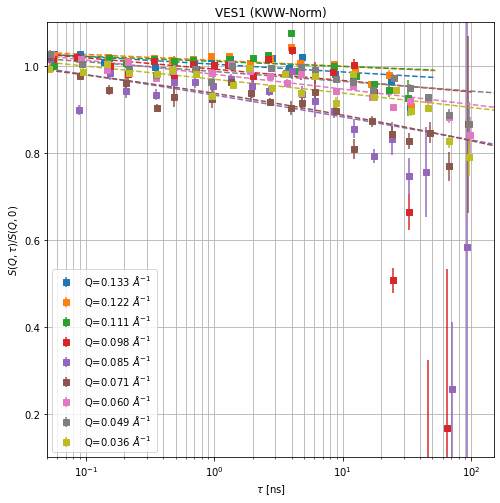

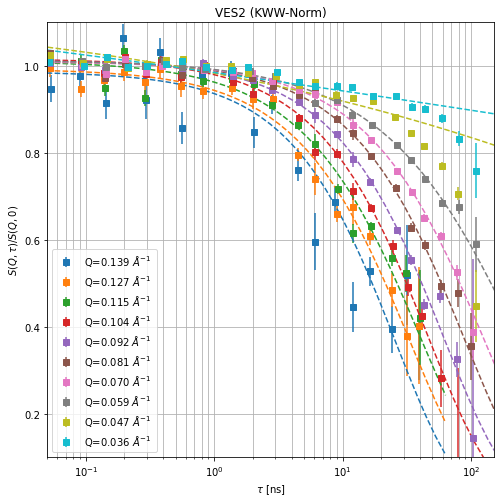

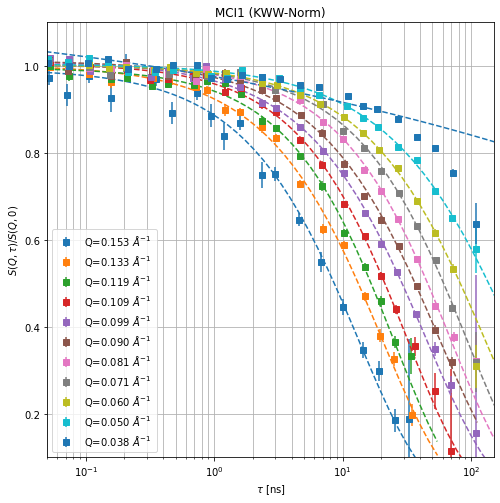

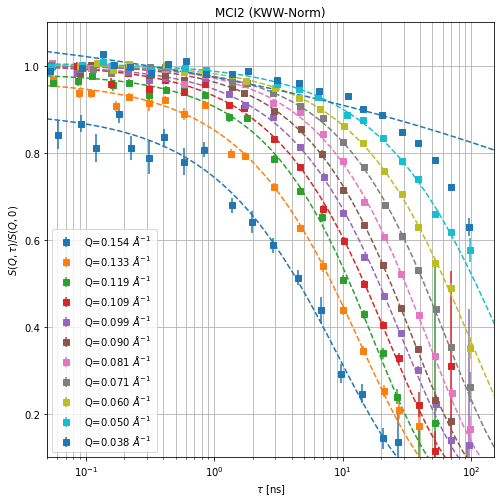

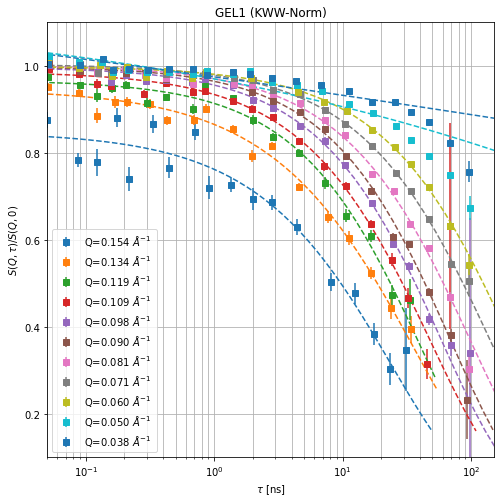

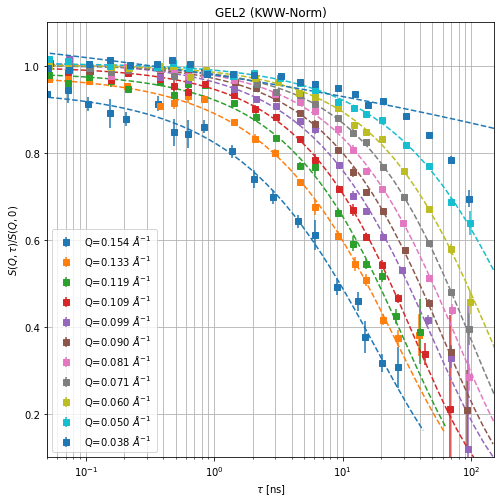

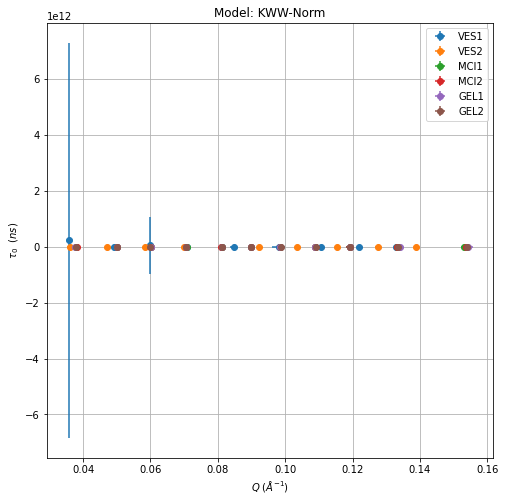

In [15]:
ves1  =      [ 'VES1', ("VES1_sqt.dat",""),]
ves2  =      [ 'VES2', ("VES2_sqt.dat",""),]

mic1  =      [ 'MCI1', ("MIC1_sqt.dat",""),]  
mic2  =      [ 'MCI2', ("MIC2_sqt.dat",""),]  

gel1  =      [ 'GEL1', ("GEL1_sqt.dat",""),]  
gel2  =      [ 'GEL2', ("GEL2_sqt.dat",""),]  
main(ves1,
     ves2, 
     mic1,
     mic2,
     gel1,
     gel2,
     model='KWW-Norm',
     plot_summary=True, plot_fits=True,data_dir='Data',)